## ✅ 임베딩이란?
**임베딩(Embedding)**은 자연어 처리에서 사람이 쓰는 자연어를 기계가 이해할 수 있도록 숫자의 나열인 벡터 형태로 바꾸는 과정입니다. 고차원 데이터를 저차원 공간으로 변환하여 의미 있는 벡터 표현을 생성하는 기법으로, 데이터의 의미적 특성을 보존하면서 데이터를 보다 효율적으로 처리할 수 있게 해줍니다. 예를 들어 king과 queen은 벡터 공간에서 비슷한 위치에 있게 됩니다.

### 📌 벡터 간 거리 계산 방법
1. 코사인 유사도<br>
벡터의 방향(각도)을 기반으로 유사성을 측정합니다. 두 벡터가 동일한 방향을 가질수록 유사도가 높습니다.
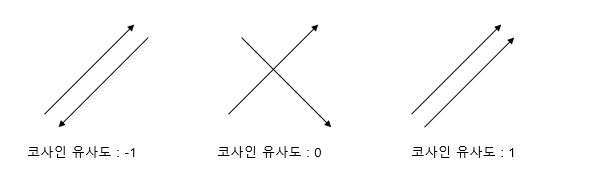
2. 유클리드 거리<br>
벡터 간의 실제 거리를 측정합니다. 거리가 짧을수록 유사성이 높습니다.

### 📌 임베딩 모델마다 성능이 다른 이유?
모델마다 아키텍쳐와 사전 학습시킨 훈련 데이터가 다르기 때문에 나의 목적에 따라 적합한 모델이 달라질 수 있습니다. 따라서 원하는 도메인 또는 서비스에서 좋은 성능을 보이는 모델을 선택해야 합니다.

---

# 실습 : Huggingface의 사전 학습된 임베딩 모델로 유사도 기반 챗봇 만들어 보기
활동 1. 알맞은 형식으로 데이터셋 생성 <br>
활동 2. 적합한 모델을 선택하여 유사도 계산 함수 생성 <br>
활동 3. Gradio로 간단한 챗봇 구현

In [ ]:
pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import json
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 모델 1 : upskyy/bge-m3-korean
- Sentence Similarity-Korean Trending TOP

In [ ]:
# 모델 불러오기
model1 = SentenceTransformer('upskyy/bge-m3-korean')

# 임베딩 테스트
sentences = ["안녕하세요?", "허깅페이스 모델들로 임베딩을 해보겠습니다."]
embeddings1 = model1.encode(sentences)

print(embeddings1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

[[ 0.56023335 -0.2838276  -0.3859377  ...  1.2831614  -0.27369404
   0.6704404 ]
 [-1.0330135  -0.07727504  1.751323   ...  1.4499453  -0.5658226
  -0.23141144]]


In [ ]:
# JSON 파일 경로
file_path = 'social_data.json'

# JSON 파일에서 데이터 불러오기
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

data[0]

{'instruction': '조선시대의 정치 체제를 설명해 주세요.',
 'input': '',
 'output': '조선시대의 정치 체제는 유교를 바탕으로 한 군주제를 채택하였습니다. 국왕이 최고 권력을 가졌고, 그 아래에는 의정부와 6조가 있어 행정, 군사, 법률, 재정 등을 담당했습니다.'}

In [ ]:
# 질문 및 답변 추출
questions = [item['instruction'] for item in data]
answers = [item['output'] for item in data]

# 모든 질문을 임베딩
question_embeddings = model1.encode(questions)

In [ ]:
def find_top_answers(user_input, top_k=3):
    # 사용자 입력을 임베딩
    user_embedding = model1.encode(user_input)

    # 입력 문장과 데이터셋 내 질문들 간의 유사도 계산
    similarities = util.cos_sim(user_embedding, question_embeddings).numpy().flatten()

    # 유사도 점수와 인덱스를 함께 저장
    indexed_similarities = list(enumerate(similarities))

    # 유사도 점수로 정렬하여 상위 top_k 개 추출
    top_similarities = sorted(indexed_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # 상위 top_k 개의 답변과 유사도 점수를 반환
    top_answers = [(answers[idx], score) for idx, score in top_similarities]

    return top_answers

# 사용자 입력에 따라 응답 생성
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break

    top_answers = find_top_answers(user_input)

    for i, (response, similarity) in enumerate(top_answers):
        print(f"Top {i+1} Answer: {response}")
        print(f"Similarity Score: {similarity:.4f}")

You: 현대사에서 중요한 건 뭐야?
Top 1 Answer: 한국 현대사에서 주요 정치적 사건 중 하나는 1980년 5.18 광주 민주화 운동입니다. 이 사건은 군사 정권의 억압에 맞서 민주주의와 인권을 위한 시민들의 항쟁을 상징하며, 한국 민주화의 중요한 전환점이 되었습니다.
Similarity Score: 0.6643
Top 2 Answer: 한국 현대사에서 주요 사회적 변화 중 하나는 산업화와 도시화입니다. 1960년대부터 시작된 경제 개발과 산업화는 한국 사회를 급격히 변화시켰고, 대규모 도시화와 함께 생활 수준이 향상되었습니다.
Similarity Score: 0.6328
Top 3 Answer: 한국 현대사에서 중요한 사회 운동 중 하나는 1987년 6월 민주항쟁입니다. 이 항쟁은 군사 독재에 대한 반발로 일어난 대규모 민주화 운동으로, 민주주의를 위한 중요한 전환점을 만들어주었습니다.
Similarity Score: 0.5926
You: 일제강점기 교육은 어땠어?
Top 1 Answer: 일제강점기 동안 일본은 한국의 교육 제도를 일본화하였으며, 한국어 교육을 제한하고 일본어 교육을 강제했습니다. 또한, 일본의 사상과 문화를 주입하기 위해 일본식 교육과정을 도입했습니다.
Similarity Score: 0.8421
Top 2 Answer: 일제강점기 동안 한국의 문화는 일본의 억압과 통제로 인해 많은 어려움을 겪었습니다. 하지만 이 시기에도 민족 문화를 지키기 위한 다양한 노력과 독립운동이 있었으며, 민속, 문학, 예술 등에서 저항의 흔적이 나타났습니다.
Similarity Score: 0.6082
Top 3 Answer: 조선시대의 교육 제도는 유교에 기반한 교육을 중심으로 구성되었습니다. 성균관을 비롯한 향교와 서원이 주요 교육 기관으로, 유교 경전과 문학, 역사 등을 교육하였습니다.
Similarity Score: 0.6017
You: 세계 2차 대전의 원인이 뭐야?
Top 1 Answer: 세계 2차 대전의 원인 중 하나는 독일의 나치즘과

KeyboardInterrupt: Interrupted by user

# 모델 2 : sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
- Sentence Similarity-Korean Most likes, Most downloads TOP

In [ ]:
model2 = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

sentences = ["안녕하세요?", "허깅페이스 모델들로 임베딩을 해보겠습니다."]
embeddings2 = model2.encode(sentences)

print(embeddings2)

[[ 3.04619104e-01  6.47533834e-02  3.36767435e-01  2.20806792e-01
  -1.38633355e-01 -2.73228526e-01  4.93074000e-01  8.01868886e-02
  -2.34597623e-01  2.06410572e-01 -4.60630003e-03 -5.29697180e-01
  -1.54207498e-01 -3.93503904e-03  1.58341482e-01  1.37235254e-01
   1.52882144e-01 -1.94419771e-01 -4.13267225e-01 -1.25771612e-01
  -3.06087881e-01  1.72429811e-02 -1.59697473e-01  5.44145703e-02
   1.44859940e-01 -6.16104826e-02  2.18530774e-01  3.95355880e-01
  -1.50611222e-01 -2.54464984e-01 -1.70916989e-01 -1.19877905e-01
   2.92654932e-01  6.86721951e-02 -7.73531571e-02  4.38518554e-01
   7.16628358e-02 -1.86873898e-01 -5.32703251e-02  3.94799411e-02
   7.60927945e-02 -2.21669078e-01  5.21893166e-02  8.92149359e-02
   3.49157639e-02 -1.39168248e-01 -1.22046128e-01  9.07691121e-02
   1.94635838e-01  1.79395750e-02 -1.43319145e-02 -2.68970504e-02
  -1.46988213e-01  1.31236583e-01  1.04323603e-01  2.35830441e-01
  -8.33186787e-03  1.93084344e-01  1.75722897e-01  1.85907573e-01
  -1.26925

In [ ]:
# 질문 및 답변 추출
questions = [item['instruction'] for item in data]
answers = [item['output'] for item in data]

# 모든 질문을 임베딩
question_embeddings = model2.encode(questions)

In [ ]:
from sentence_transformers import util
import numpy as np

def find_top_answers(user_input, top_k=3):
    # 사용자 입력을 임베딩
    user_embedding = model2.encode(user_input)

    # 입력 문장과 데이터셋 내 질문들 간의 유사도 계산
    similarities = util.cos_sim(user_embedding, question_embeddings).numpy().flatten()

    # 유사도 점수와 인덱스를 함께 저장
    indexed_similarities = list(enumerate(similarities))

    # 유사도 점수로 정렬하여 상위 top_k 개 추출
    top_similarities = sorted(indexed_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # 상위 top_k 개의 답변과 유사도 점수를 반환
    top_answers = [(answers[idx], score) for idx, score in top_similarities]

    return top_answers

# 사용자 입력에 따라 응답 생성
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break

    top_answers = find_top_answers(user_input)

    for i, (response, similarity) in enumerate(top_answers):
        print(f"Top {i+1} Answer: {response}")
        print(f"Similarity Score: {similarity:.4f}")

You: 현대사에서 중요한 건 뭐야?
Top 1 Answer: 고려시대의 사회 구조는 왕족, 귀족, 중인, 상민, 노비로 나뉘어 있었습니다. 왕족과 귀족은 정치적 권력을 가지며, 중인과 상민은 경제적 역할을 담당했고, 노비는 농업과 공업 분야에서 노동력을 제공했습니다.
Similarity Score: 0.6129
Top 2 Answer: 한국 현대사에서 주요 사회적 변화 중 하나는 산업화와 도시화입니다. 1960년대부터 시작된 경제 개발과 산업화는 한국 사회를 급격히 변화시켰고, 대규모 도시화와 함께 생활 수준이 향상되었습니다.
Similarity Score: 0.4571
Top 3 Answer: 고려시대는 중앙집권적인 왕권 아래에서 귀족들의 권력이 강한 정치 체제를 가지고 있었습니다. 국왕은 최고 권력자로서 국가의 행정을 총괄하였고, 귀족들은 중앙과 지방에서 권력을 행사하였습니다.
Similarity Score: 0.4283
You: 일제강점기 교육은 어땠어?
Top 1 Answer: 조선시대의 교육 제도는 유교에 기반한 교육을 중심으로 구성되었습니다. 성균관을 비롯한 향교와 서원이 주요 교육 기관으로, 유교 경전과 문학, 역사 등을 교육하였습니다.
Similarity Score: 0.5981
Top 2 Answer: 일제강점기 동안 일본은 한국의 교육 제도를 일본화하였으며, 한국어 교육을 제한하고 일본어 교육을 강제했습니다. 또한, 일본의 사상과 문화를 주입하기 위해 일본식 교육과정을 도입했습니다.
Similarity Score: 0.5431
Top 3 Answer: 고려시대의 사회 구조는 왕족, 귀족, 중인, 상민, 노비로 나뉘어 있었습니다. 왕족과 귀족은 정치적 권력을 가지며, 중인과 상민은 경제적 역할을 담당했고, 노비는 농업과 공업 분야에서 노동력을 제공했습니다.
Similarity Score: 0.3840
You: 세계 2차 대전의 원인이 뭐야?
Top 1 Answer: 세계 2차 대전의 원인 중 하나는 독일의 나치즘과 군국주의적 팽창주의입니다. 

KeyboardInterrupt: Interrupted by user

# 모델 3 : jhgan/ko-sroberta-multitask

In [ ]:
model3 = SentenceTransformer('jhgan/ko-sroberta-multitask')

sentences = ["안녕하세요?", "허깅페이스 모델들로 임베딩을 해보겠습니다."]
embeddings3 = model3.encode(sentences)

print(embeddings3)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.37510464 -0.77338415  0.5927709  ...  0.5792353   0.32683468
  -0.6508964 ]
 [-0.80939364 -0.13910297  0.2642859  ...  0.11080029 -0.26531
  -0.2920881 ]]


In [ ]:
# 질문 및 답변 추출
questions = [item['instruction'] for item in data]
answers = [item['output'] for item in data]

# 모든 질문을 임베딩
question_embeddings = model3.encode(questions)

In [ ]:
from sentence_transformers import util
import numpy as np

def find_top_answers(user_input, top_k=3):
    # 사용자 입력을 임베딩
    user_embedding = model3.encode(user_input)

    # 입력 문장과 데이터셋 내 질문들 간의 유사도 계산
    similarities = util.cos_sim(user_embedding, question_embeddings).numpy().flatten()

    # 유사도 점수와 인덱스를 함께 저장
    indexed_similarities = list(enumerate(similarities))

    # 유사도 점수로 정렬하여 상위 top_k 개 추출
    top_similarities = sorted(indexed_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # 상위 top_k 개의 답변과 유사도 점수를 반환
    top_answers = [(answers[idx], score) for idx, score in top_similarities]

    return top_answers

# 사용자 입력에 따라 응답 생성
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break

    top_answers = find_top_answers(user_input)

    for i, (response, similarity) in enumerate(top_answers):
        print(f"Top {i+1} Answer: {response}")
        print(f"Similarity Score: {similarity:.4f}")

You: 현대사에서 중요한 건 뭐야?
Top 1 Answer: 한국 현대사에서 주요 정치적 사건 중 하나는 1980년 5.18 광주 민주화 운동입니다. 이 사건은 군사 정권의 억압에 맞서 민주주의와 인권을 위한 시민들의 항쟁을 상징하며, 한국 민주화의 중요한 전환점이 되었습니다.
Similarity Score: 0.7591
Top 2 Answer: 한국 현대사에서 중요한 사회 운동 중 하나는 1987년 6월 민주항쟁입니다. 이 항쟁은 군사 독재에 대한 반발로 일어난 대규모 민주화 운동으로, 민주주의를 위한 중요한 전환점을 만들어주었습니다.
Similarity Score: 0.7355
Top 3 Answer: 한국 현대사에서 주요 사회적 변화 중 하나는 산업화와 도시화입니다. 1960년대부터 시작된 경제 개발과 산업화는 한국 사회를 급격히 변화시켰고, 대규모 도시화와 함께 생활 수준이 향상되었습니다.
Similarity Score: 0.7349
You: 일제강점기 교육은 어땠어?
Top 1 Answer: 일제강점기 동안 일본은 한국의 교육 제도를 일본화하였으며, 한국어 교육을 제한하고 일본어 교육을 강제했습니다. 또한, 일본의 사상과 문화를 주입하기 위해 일본식 교육과정을 도입했습니다.
Similarity Score: 0.8000
Top 2 Answer: 일제강점기 동안 한국의 문화는 일본의 억압과 통제로 인해 많은 어려움을 겪었습니다. 하지만 이 시기에도 민족 문화를 지키기 위한 다양한 노력과 독립운동이 있었으며, 민속, 문학, 예술 등에서 저항의 흔적이 나타났습니다.
Similarity Score: 0.6599
Top 3 Answer: 일제강점기 동안 한국은 일본의 경제적 착취를 받았습니다. 일본은 한국의 자원을 착취하고, 일본 기업의 이익을 위해 한국의 경제를 구조적으로 변형시켰습니다. 이로 인해 한국 경제는 크게 침체되었고, 많은 사회적 고통을 겪었습니다.
Similarity Score: 0.6015
You: 세계 2차 대전의 원인이 뭐야?
Top 1 A

KeyboardInterrupt: Interrupted by user

# Gradio로 간단 챗봇 구현

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 235.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2

In [ ]:
import gradio as gr
from sentence_transformers import SentenceTransformer, util
import json

# 모델 로드
model = SentenceTransformer('upskyy/bge-m3-korean')

# 데이터 로드
def load_data():
    with open('korean_data.json', 'r') as f:
        korean_data = json.load(f)
    with open('math_data.json', 'r') as f:
        math_data = json.load(f)
    with open('english_data.json', 'r') as f:
        english_data = json.load(f)
    with open('social_data.json', 'r') as f:
        social_data = json.load(f)
    with open('science_data.json', 'r') as f:
        science_data = json.load(f)
    return korean_data, math_data, english_data, social_data, science_data

# 데이터 준비
def prepare_data(data):
    questions = [entry['instruction'] for entry in data]
    answers = [entry['output'] for entry in data]
    question_embeddings = model.encode(questions, convert_to_tensor=True)
    return question_embeddings, questions, answers

korean_data, math_data, english_data, social_data, science_data = load_data()
korean_embeddings, korean_questions, korean_answers = prepare_data(korean_data)
math_embeddings, math_questions, math_answers = prepare_data(math_data)
english_embeddings, english_questions, english_answers = prepare_data(english_data)
social_embeddings, social_questions, social_answers = prepare_data(social_data)
science_embeddings, science_questions, science_answers = prepare_data(science_data)

# 유사도 검색 함수
def find_top_answers(user_input, question_embeddings, questions, answers, top_k=3):
    user_embedding = model.encode(user_input, convert_to_tensor=True)
    similarities = util.cos_sim(user_embedding, question_embeddings).cpu().numpy().flatten()
    indexed_similarities = list(enumerate(similarities))
    top_similarities = sorted(indexed_similarities, key=lambda x: x[1], reverse=True)[:top_k]
    top_answers = [(answers[idx], score) for idx, score in top_similarities]
    return top_answers

# 챗봇 응답 함수
def chatbot(subject, user_input):
    if subject == '국어':
        embeddings, questions, answers = korean_embeddings, korean_questions, korean_answers
    elif subject == '수학':
        embeddings, questions, answers = math_embeddings, math_questions, math_answers
    elif subject == '영어':
        embeddings, questions, answers = english_embeddings, english_questions, english_answers
    elif subject == '사회/역사':
        embeddings, questions, answers = social_embeddings, social_questions, social_answers
    elif subject == '과학':
        embeddings, questions, answers = science_embeddings, science_questions, science_answers
    else:
        return "과목을 선택해 주세요."

    top_answers = find_top_answers(user_input, embeddings, questions, answers)
    response_text = ""
    for i, (response, similarity) in enumerate(top_answers):
        response_text += f"Top {i+1} Answer: {response}\nSimilarity Score: {similarity:.4f}\n"
    return response_text

# Gradio 인터페이스 설정
def gradio_interface(subject, user_input):
    return chatbot(subject, user_input)

iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Dropdown(
            label="과목을 선택하세요",
            choices=['국어', '수학', '영어', '사회/역사', '과학'],
            type="value"
        ),
        gr.Textbox(label="질문을 입력하세요")
    ],
    outputs="text",
    title="학습 챗봇",
    description="어떤 과목이 궁금하신가요? 과목을 선택하고 질문을 입력해 주세요."
)

iface.launch(debug = True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2befb1d6cb6753f6bd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://2befb1d6cb6753f6bd.gradio.live
